# Reddit Classification Task

This project aims to accomplish a task of building a classifier model that accurately classifies a list of reddit comments into the proper labels of Medical Doctor, Veterinarian and Others. 
The classifier model explored was based on Neural Networks focusing on Convolutional Neural Network (CNN) due to its performance in performing classification tasks.

In [1]:
#libraries needed to run this code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline


**Data Preprocessing**

In [2]:
# Load the data
reddit_data = pd.read_csv('reddit_usernames_comments.csv')

In [3]:
reddit_data.head(5)

,username,comments
0,--solaris--,I think a lot of other people made some good p...
1,-Mother_of_Doggos,"No, and it doesn’t suit you based on what you’..."
2,-Tasear-,It's just the adjustment period to any new pla...
3,-Zyonia-,I am living this currently and when a trainee ...
4,-p-OodlesOfNoodles,Well that's disappointing that there is no cha...


In [4]:
reddit_data.shape

(3259, 2)

In [5]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3259 entries, 0 to 3258
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  3259 non-null   object
 1   comments  3259 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB


In [6]:
reddit_data.describe()

,username,comments
count,3259,3259
unique,3259,3258
top,--solaris--,Why?|Why?|Why?|Why?|Why?|Why?
freq,1,2


In [7]:
# Cleaning text data: lowercasing and removing punctuation
reddit_data['cleaned_comments'] = reddit_data['comments'].str.lower().str.replace('[^\\w\\s]', '', regex=True)

In [8]:
#using a search function to create the target category column with which the model will be trained on
# Define keywords for each category

medical_keywords = ['medical doctor', 'practicing doctor', 'medical school student', 'nurse', 'medical professional', 'doctor', 'Dr', 'healthcare provider']
veterinarian_keywords = ['veterinarian', 'practicing vet', 'vet student', 'vet tech', 'vet', 'animal doctor']

# Function to classify each comment and extract the keyword
def classify_comment(comment):
    # Check for Medical keywords
    for keyword in medical_keywords:
        if keyword in comment.lower():
            return keyword, 'Medical Doctor'
    # Check for Veterinarian keywords
    for keyword in veterinarian_keywords:
        if keyword in comment.lower():
            return keyword, 'Veterinarian'
    # Default to Others
    return 'Others', 'Others'

# Apply the classification function to each comment
reddit_data['profession'], reddit_data['category'] = zip(*reddit_data['comments'].apply(classify_comment))

In [9]:
reddit_data.to_csv('labelled_reddit.csv')

In [10]:
reddit_data['category'].value_counts()

Others            1991
Veterinarian       906
Medical Doctor     362
Name: category, dtype: int64

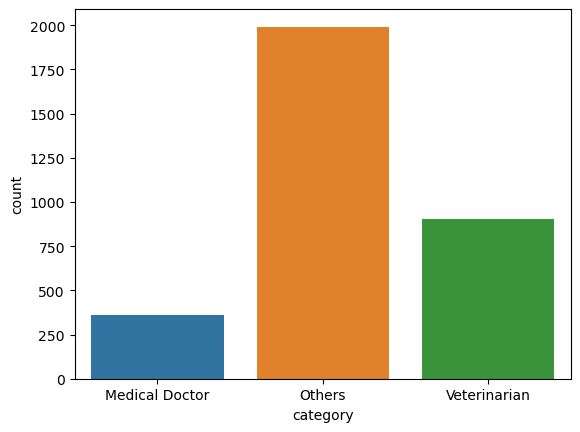

In [11]:
sns.countplot(x='category', data=reddit_data)
plt.show()



**Model Training**

In [12]:
text = reddit_data['cleaned_comments']
labels = reddit_data['category']

# Split the dataset into training and testing sets

train_texts, test_texts, train_labels, test_labels = train_test_split(reddit_data['cleaned_comments'], reddit_data['category'], test_size=0.4, random_state=30)

In [13]:
# Encode the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

In [14]:
# Tokenize the texts
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [15]:
# Pad sequences to have the same length
max_seq_length = 500
train_data = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data = pad_sequences(test_sequences, maxlen=max_seq_length)

In [16]:
# Create the CNN model
embedding_dim = 100
filters = 128
kernel_size = 5

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_seq_length))
model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
epochs = 10
batch_size = 32

history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_data, test_labels))

Epoch 1/10
62/62 [==============================] - 5s 70ms/step - loss: 0.8830 - accuracy: 0.6297 - val_loss: 0.6869 - val_accuracy: 0.7078
Epoch 2/10
62/62 [==============================] - 4s 68ms/step - loss: 0.4458 - accuracy: 0.8368 - val_loss: 0.3248 - val_accuracy: 0.8719
Epoch 3/10
62/62 [==============================] - 4s 68ms/step - loss: 0.2836 - accuracy: 0.8737 - val_loss: 0.2985 - val_accuracy: 0.8781
Epoch 4/10
62/62 [==============================] - 4s 67ms/step - loss: 0.2309 - accuracy: 0.8957 - val_loss: 0.2825 - val_accuracy: 0.8957
Epoch 5/10
62/62 [==============================] - 4s 65ms/step - loss: 0.1559 - accuracy: 0.9499 - val_loss: 0.1995 - val_accuracy: 0.9448
Epoch 6/10
62/62 [==============================] - 4s 69ms/step - loss: 0.0570 - accuracy: 0.9847 - val_loss: 0.1565 - val_accuracy: 0.9632
Epoch 7/10
62/62 [==============================] - 4s 68ms/step - loss: 0.0234 - accuracy: 0.9959 - val_loss: 0.1600 - val_accuracy: 0.9663
Epoch 8/10
62

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels, batch_size=batch_size)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

41/41 [==============================] - 0s 11ms/step - loss: 0.1886 - accuracy: 0.9663
Test Loss: 0.1886
Test Accuracy: 0.9663


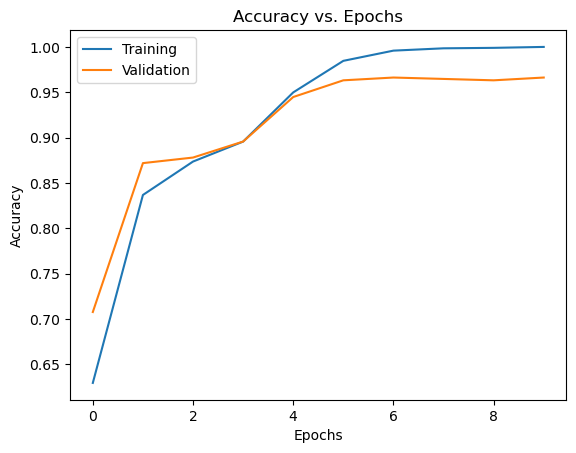

In [19]:
# Plot accuracy vs. epochs
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy vs. Epochs')
plt.show()

In [20]:
loss = history.history['loss']

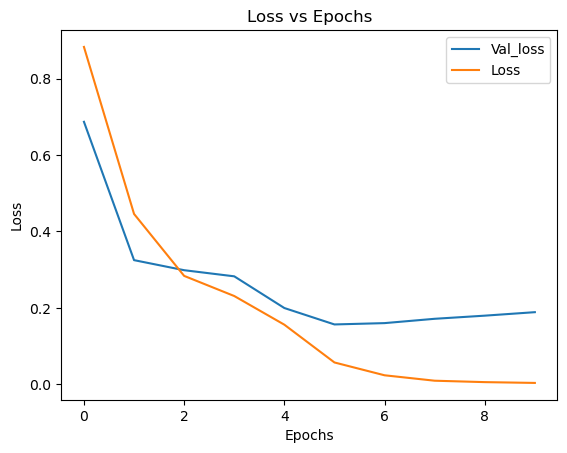

In [21]:
# Plot the loss vs epochs graph
plt.plot(history.history['val_loss'])
plt.plot(loss)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val_loss', 'Loss'])
plt.show()

In [22]:
# Save the trained model
model.save('reddit_comment_classifier_model.h5')

C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluation on Newly prepared dataset

Note only run for the evaluation of the dataset

In [23]:
# import pandas as pd
# import numpy as np
# import re
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelEncoder

# # Load and preprocess the new dataset
# def load_and_preprocess_new_data(file_path):
#     # Load the new data
#     new_data = pd.read_csv(file_path)
    
#     # Preprocess the comments
#     def preprocess_text(text):
#         text = re.sub(r'http\S+|www\S+|https\S+|@\S+', '', text, flags=re.MULTILINE)
#         text = re.sub(r'\@w+|\#','', text)
#         text = re.sub(r'[^A-Za-z\s]', '', text)
#         text = re.sub(r'\d+', '', text)
#         text = text.lower()
#         return text

#     new_data['comment'] = new_data['comment'].apply(preprocess_text)
    
#     return new_data['comment'].values

# # Tokenize and pad the new data
# def tokenize_and_pad_sequences(new_comments, tokenizer, max_length):
#     new_sequences = tokenizer.texts_to_sequences(new_comments)
#     new_padded = pad_sequences(new_sequences, maxlen=max_length, padding='post', truncating='post')
#     return new_padded

# # Load the new dataset
# new_file_path = '/path/to/new/reddit_comments.csv'  # Update with the actual path
# new_comments = load_and_preprocess_new_data(new_file_path)

# # Tokenize and pad the new data
# new_sequences = tokenize_and_pad_sequences(new_comments, tokenizer, max_length)

# # Load the saved model
# loaded_model = tf.keras.models.load_model('/mnt/data/reddit_comment_classifier_model.h5')

# # Make predictions on the new data
# new_predictions = loaded_model.predict(new_sequences)
# new_predicted_labels = np.argmax(new_predictions, axis=1)

# # Convert numeric labels back to original labels
# new_predicted_labels = label_encoder.inverse_transform(new_predicted_labels)

# # Display the predictions
# for comment, label in zip(new_comments, new_predicted_labels):
#     print(f'Comment: {comment}\nPredicted Label: {label}\n')